In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from time import time
%matplotlib notebook

In [2]:
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/positive_cropped.mat"
mal_dict = loadmat(path)
infected = mal_dict['stack']
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/negative_cropped.mat"
wmal_dict = loadmat(path)
normal = wmal_dict['stack']
infected = np.moveaxis(infected, -1, 0)
normal = np.moveaxis(normal, -1, 0)

infected_train, infected_test = train_test_split(infected, test_size = 0.2)
normal_train, normal_test = train_test_split(normal, test_size = 0.2)
data = (infected_train, infected_test, normal_train, normal_test)

In [3]:
add_noise = True
pixel_well_depth = 20000
batch_size = 32
numcategories = 2
image_dim = 28
numchannel = 3

In [4]:
def to_one_hot(y,numcategories = 2):
    y_ = np.zeros((y.size,numcategories))
    y_[np.arange(y.size),y]=1
    return y_

In [5]:
def get_feed_dict_superposition(data, n = 0, training=True):
    # data is the output of load_data_malaria
    # n+1 is the number of images summed, where one is malaria-infected
    # intensity_scale: tune this value so that the detector doesn't saturate
    # training specifies whether to generate from the training data or validation data
    # returns a feed_dict for training (or validation)
    intensity_scale = 1/(n+1)
    X1train, X1val, X0train, X0val = data
    
    if training:
        X0 = X0train
        X1 = X1train
        #X0 = np.mean(X0, 3)[:, :, :, None]  # keep color channel for CNN
        #X1 = np.mean(X1, 3)[:, :, :, None]
    else:
        X0 = X0val
        X1 = X1val
        #X0 = np.mean(X0, 3)[:, :, :, None]  # keep color channel for CNN
        #X1 = np.mean(X1, 3)[:, :, :, None]
    
    s0 = X0.shape
    s1 = X1.shape
    
    # make half of the batch no malaria, half with malaria
    inds0 = np.random.choice(s0[0],size=batch_size*(n+1)-batch_size//2) #for the non-malaria
    inds1 = np.random.choice(s1[0],size=batch_size//2) #for the malaria; only 1 malaria per stack; for half of the batch
    
    # examples for no malaria in stack
    X0stack = X0[inds0[:batch_size//2*(n+1)]].reshape(batch_size//2,n+1,s0[1],s0[2],s0[3])
    X0stack = X0stack.sum(1) #the superpositioned image
    
    # examples for one malaria in stack
    X1stack0 = X0[inds0[batch_size//2*(n+1):]].reshape(batch_size//2,n,s0[1],s0[2],s0[3]) #from the nonmalaria set
    X1stack1 = X1[inds1]
    X1stack = X1stack0.sum(1) + X1stack1
    
    # stack them all together
    Xbatch = np.concatenate([X0stack,X1stack],axis=0)*intensity_scale
    if add_noise:
        Xbatch += np.random.normal(loc=0, scale=np.sqrt(Xbatch*(1-1/(n+1)/numchannel)*256/pixel_well_depth))
    Xbatch = np.minimum(Xbatch,255).astype(np.uint8).astype(np.float32) # threshold and discretize to 8-bit
    ybatch = np.concatenate([np.zeros(batch_size//2,dtype=np.int32),np.ones(batch_size//2,dtype=np.int32)])
    ybatch = to_one_hot(ybatch)
    
    return {X:Xbatch, y:ybatch}

In [6]:
def pass_through_validation(rawdata, n, sess, numbatches, use_random_seed=True):
    #there's no longer a fixed validation set: generate on the fly
    if use_random_seed:
        np.random.seed(0)
    acc = 0
    for i in range(numbatches):
        feed = get_feed_dict_superposition(rawdata, n=n, training=False)
        acc += sess.run(accuracy, feed_dict=feed)
    return acc/numbatches

In [7]:
def CNN2(net,labels,numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net #return net to examine accuracy

In [8]:
acc = list()
fulls = time()
for n in range(15):
    tf.reset_default_graph() 
    sess = tf.Session()
    X = tf.placeholder(dtype=tf.float32, name='data', shape=(batch_size, image_dim, image_dim, numchannel))
    y = tf.placeholder(dtype=tf.int32, name='labels', shape=(batch_size, numcategories))
    pred = CNN2(X, y, 2)  # add batch dim
    loss = tf.losses.softmax_cross_entropy(logits=pred, onehot_labels=y)
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
    prediction = tf.argmax(pred,1)
    truth = tf.argmax(y,1)
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction,truth)))
    
    Accuracy = list()
    for runs in range (5):
        sess.run(tf.global_variables_initializer())
        train_losses = list()
        val_losses = list()
        start=time()
        for i in range(251):
            feed = get_feed_dict_superposition(data, n = n, training = True)
            _, tloss = sess.run([train_op, loss], feed_dict = feed)
            train_losses.append(tloss)
            if i%50==0:
                val_losses.append(pass_through_validation(data, n, sess, numbatches=30))
                print("iteration %d; batch classifier loss: %f; batch Validation accuracy: %f; Time passed in this loop: %.2f" % 
                      (i,train_losses[-1],val_losses[-1],time()-start))
        Accuracy.append(val_losses[-1])
    mean = sum(Accuracy)/5
    acc.append(mean)
    sess.close()
fulle = time()

iteration 0; batch classifier loss: 0.947978; batch Validation accuracy: 0.500000; Time passed in this loop: 1.59
iteration 50; batch classifier loss: 0.004285; batch Validation accuracy: 0.987500; Time passed in this loop: 2.27
iteration 100; batch classifier loss: 0.003081; batch Validation accuracy: 0.995833; Time passed in this loop: 2.96
iteration 150; batch classifier loss: 0.001241; batch Validation accuracy: 0.993750; Time passed in this loop: 3.65
iteration 200; batch classifier loss: 0.000926; batch Validation accuracy: 0.991667; Time passed in this loop: 4.33
iteration 250; batch classifier loss: 0.000265; batch Validation accuracy: 0.991667; Time passed in this loop: 5.02
iteration 0; batch classifier loss: 1.470854; batch Validation accuracy: 0.500000; Time passed in this loop: 0.18
iteration 50; batch classifier loss: 0.022495; batch Validation accuracy: 0.985417; Time passed in this loop: 0.86
iteration 100; batch classifier loss: 0.005994; batch Validation accuracy: 0.9

iteration 250; batch classifier loss: 0.012538; batch Validation accuracy: 0.971875; Time passed in this loop: 3.84
iteration 0; batch classifier loss: 1.669512; batch Validation accuracy: 0.500000; Time passed in this loop: 0.18
iteration 50; batch classifier loss: 0.225935; batch Validation accuracy: 0.916667; Time passed in this loop: 0.90
iteration 100; batch classifier loss: 0.060616; batch Validation accuracy: 0.958333; Time passed in this loop: 1.62
iteration 150; batch classifier loss: 0.055346; batch Validation accuracy: 0.967708; Time passed in this loop: 2.35
iteration 200; batch classifier loss: 0.031125; batch Validation accuracy: 0.965625; Time passed in this loop: 3.07
iteration 250; batch classifier loss: 0.013198; batch Validation accuracy: 0.975000; Time passed in this loop: 3.80
iteration 0; batch classifier loss: 0.682395; batch Validation accuracy: 0.500000; Time passed in this loop: 0.18
iteration 50; batch classifier loss: 0.207648; batch Validation accuracy: 0.9

iteration 200; batch classifier loss: 0.013067; batch Validation accuracy: 0.956250; Time passed in this loop: 3.30
iteration 250; batch classifier loss: 0.013146; batch Validation accuracy: 0.942708; Time passed in this loop: 4.14
iteration 0; batch classifier loss: 0.842751; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.401649; batch Validation accuracy: 0.798958; Time passed in this loop: 1.03
iteration 100; batch classifier loss: 0.157780; batch Validation accuracy: 0.851042; Time passed in this loop: 1.79
iteration 150; batch classifier loss: 0.036560; batch Validation accuracy: 0.927083; Time passed in this loop: 2.58
iteration 200; batch classifier loss: 0.015197; batch Validation accuracy: 0.945833; Time passed in this loop: 3.35
iteration 250; batch classifier loss: 0.010963; batch Validation accuracy: 0.936458; Time passed in this loop: 4.16
iteration 0; batch classifier loss: 1.704332; batch Validation accuracy: 0.

iteration 150; batch classifier loss: 0.137955; batch Validation accuracy: 0.872917; Time passed in this loop: 2.76
iteration 200; batch classifier loss: 0.052737; batch Validation accuracy: 0.944792; Time passed in this loop: 3.53
iteration 250; batch classifier loss: 0.036373; batch Validation accuracy: 0.948958; Time passed in this loop: 4.33
iteration 0; batch classifier loss: 1.358992; batch Validation accuracy: 0.500000; Time passed in this loop: 0.20
iteration 50; batch classifier loss: 0.524782; batch Validation accuracy: 0.760417; Time passed in this loop: 1.05
iteration 100; batch classifier loss: 0.274322; batch Validation accuracy: 0.820833; Time passed in this loop: 1.88
iteration 150; batch classifier loss: 0.210704; batch Validation accuracy: 0.937500; Time passed in this loop: 2.71
iteration 200; batch classifier loss: 0.072704; batch Validation accuracy: 0.919792; Time passed in this loop: 3.51
iteration 250; batch classifier loss: 0.057439; batch Validation accuracy: 

iteration 100; batch classifier loss: 0.258898; batch Validation accuracy: 0.836458; Time passed in this loop: 1.80
iteration 150; batch classifier loss: 0.259740; batch Validation accuracy: 0.902083; Time passed in this loop: 2.59
iteration 200; batch classifier loss: 0.201352; batch Validation accuracy: 0.922917; Time passed in this loop: 3.39
iteration 250; batch classifier loss: 0.198559; batch Validation accuracy: 0.933333; Time passed in this loop: 4.18
iteration 0; batch classifier loss: 1.312421; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.613332; batch Validation accuracy: 0.740625; Time passed in this loop: 1.04
iteration 100; batch classifier loss: 0.463441; batch Validation accuracy: 0.771875; Time passed in this loop: 1.84
iteration 150; batch classifier loss: 0.195054; batch Validation accuracy: 0.836458; Time passed in this loop: 2.66
iteration 200; batch classifier loss: 0.165495; batch Validation accuracy: 

iteration 50; batch classifier loss: 0.632099; batch Validation accuracy: 0.705208; Time passed in this loop: 1.09
iteration 100; batch classifier loss: 0.555207; batch Validation accuracy: 0.806250; Time passed in this loop: 1.93
iteration 150; batch classifier loss: 0.468377; batch Validation accuracy: 0.863542; Time passed in this loop: 2.76
iteration 200; batch classifier loss: 0.374236; batch Validation accuracy: 0.927083; Time passed in this loop: 3.56
iteration 250; batch classifier loss: 0.225016; batch Validation accuracy: 0.925000; Time passed in this loop: 4.37
iteration 0; batch classifier loss: 0.705576; batch Validation accuracy: 0.500000; Time passed in this loop: 0.45
iteration 50; batch classifier loss: 0.649384; batch Validation accuracy: 0.590625; Time passed in this loop: 1.27
iteration 100; batch classifier loss: 0.549213; batch Validation accuracy: 0.715625; Time passed in this loop: 2.09
iteration 150; batch classifier loss: 0.509815; batch Validation accuracy: 0

iteration 0; batch classifier loss: 1.130389; batch Validation accuracy: 0.500000; Time passed in this loop: 0.22
iteration 50; batch classifier loss: 0.681054; batch Validation accuracy: 0.548958; Time passed in this loop: 1.07
iteration 100; batch classifier loss: 0.605365; batch Validation accuracy: 0.751042; Time passed in this loop: 1.91
iteration 150; batch classifier loss: 0.642482; batch Validation accuracy: 0.825000; Time passed in this loop: 2.77
iteration 200; batch classifier loss: 0.315754; batch Validation accuracy: 0.873958; Time passed in this loop: 3.63
iteration 250; batch classifier loss: 0.231871; batch Validation accuracy: 0.856250; Time passed in this loop: 4.49
iteration 0; batch classifier loss: 1.153175; batch Validation accuracy: 0.500000; Time passed in this loop: 0.23
iteration 50; batch classifier loss: 0.681459; batch Validation accuracy: 0.565625; Time passed in this loop: 1.13
iteration 100; batch classifier loss: 0.632045; batch Validation accuracy: 0.7

In [9]:
acc

[0.9939583333333333,
 0.9808333333333333,
 0.9772916666666667,
 0.9491666666666667,
 0.94625,
 0.9600000000000002,
 0.9356249999999999,
 0.9291666666666666,
 0.911875,
 0.8920833333333332,
 0.9041666666666668,
 0.899375,
 0.8627083333333333,
 0.8225000000000001,
 0.8210416666666667]

In [10]:
fulle-fulls

350.28565859794617

Text(0, 0.5, 'accuracy')

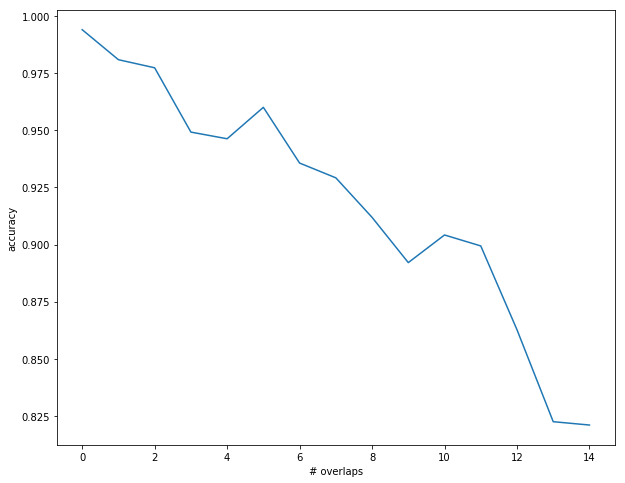

In [11]:
plt.figure(figsize=(10,8))
plt.plot(acc)
plt.xlabel("# overlaps")
plt.ylabel("accuracy")

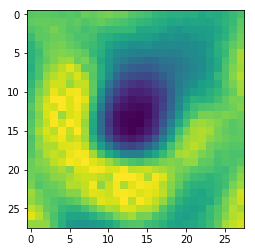

In [12]:
feed = get_feed_dict_superposition(data, n = 0, training = True)
plt.imshow(feed[X][20][:,:,0].astype(np.uint8))